In [120]:
%matplotlib inline
%load_ext autoreload
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io
import datetime
from math import ceil

import matplotlib.pyplot as plt
import matplotlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
from scipy.spatial.distance import cdist

In [123]:
images = scipy.io.loadmat("mnist_data/images.mat")['images'].T.reshape((60000,784)) / 255
np.random.shuffle(images)
images.shape

(60000, 784)

In [124]:
class KMeans:
    def __init__(self, k=5, num_iters=10, seed=10):
        self.k = k
        self.num_iters = num_iters
        self.losses = []
        self.seed = seed
        self.means = None
        self.start = None # keep track of where we started

    def fit(self, X, y=None):
        n_examples, n_features = X.shape
        np.random.seed(self.seed)
        start = X[np.random.choice(len(X), self.k, False)]
        start = np.abs(np.random.normal(X.mean(axis=0).mean(), X.mean(axis=0).std(), size=(self.k, n_features)))
        self.start = start
        self.means = start
        for it in range(self.num_iters):
            assignments = self.predict(X)
            for mean in range(self.k):
                self.means[mean] = X[assignments == mean].mean(axis=0)
        self.mean_stats(X)
        return self
    
    def loss(self, pred_values):
        loss = []
        assignments = pred_values.argmin(axis=1)
        for mean in range(self.k):
            n_assign = pred_values[assignments == mean].sum()
            loss.append(n_assign/len(assignments))
        self.losses.append(loss)
        
    def mean_stats(self, X):
        preds = self.predict(X)
        pd.DataFrame(self.losses).plot()
        pd.DataFrame(self.losses).sum(axis=1).plot()
        for mean in range(self.k):
            print("Number in Mean Number %i %i" % (mean, len(X[preds == mean])))
            
    def plot_means(self, figsize=(10,8)):
        fig = plt.figure(figsize=figsize)
        gs = matplotlib.gridspec.GridSpec(ceil(self.k/2), 2, width_ratios=[1,1])
        for mean, ax in zip(range(self.k),gs):
            sp = plt.subplot(ax)
            sp.imshow(self.means[mean].reshape((28,28)))
            sp.set_title("Mean Number: %i" % mean)
            sp.set_axis_off()     

    def predict(self, X, y=None):
        pred_values = cdist(X, self.means, 'euclidean')
        self.loss(pred_values)
        return pred_values.argmin(axis=1)

458
Number in Mean Number 0 11420
Number in Mean Number 1 11034
Number in Mean Number 2 11898
Number in Mean Number 3 11431
Number in Mean Number 4 14217


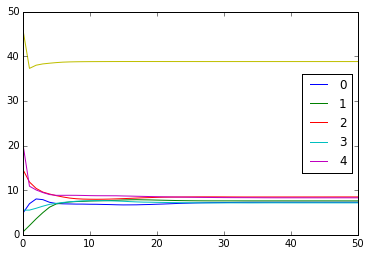

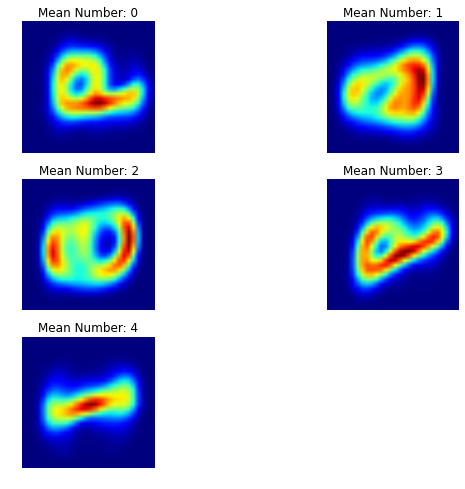

In [125]:
%autoreload
s = np.random.randint(0, 1000)
print(s)
k = 5
it = 50
km = KMeans(k, it, s).fit(images).plot_means()

184
Number in Mean Number 0 4390
Number in Mean Number 1 5348
Number in Mean Number 2 7331
Number in Mean Number 3 4738
Number in Mean Number 4 10413
Number in Mean Number 5 6829
Number in Mean Number 6 5310
Number in Mean Number 7 4399
Number in Mean Number 8 6352
Number in Mean Number 9 4890


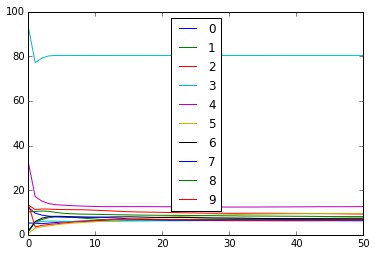

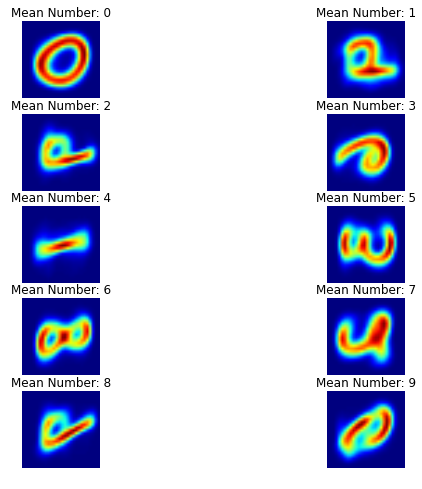

In [126]:
%autoreload
s = np.random.randint(0, 1000)
print(s)
k = 10
km = KMeans(k, it, s).fit(images).plot_means()

701
Number in Mean Number 0 2624
Number in Mean Number 1 4644
Number in Mean Number 2 2879
Number in Mean Number 3 2530
Number in Mean Number 4 2950
Number in Mean Number 5 3745
Number in Mean Number 6 2494
Number in Mean Number 7 3505
Number in Mean Number 8 2366
Number in Mean Number 9 2334
Number in Mean Number 10 3532
Number in Mean Number 11 2299
Number in Mean Number 12 3414
Number in Mean Number 13 2691
Number in Mean Number 14 2381
Number in Mean Number 15 3018
Number in Mean Number 16 1604
Number in Mean Number 17 3087
Number in Mean Number 18 3549
Number in Mean Number 19 4354


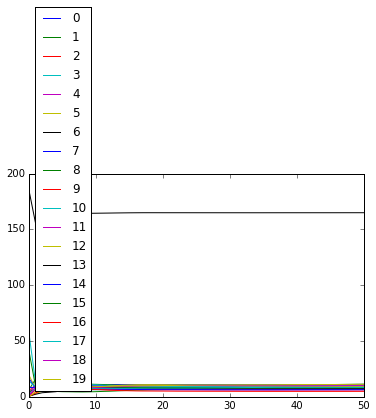

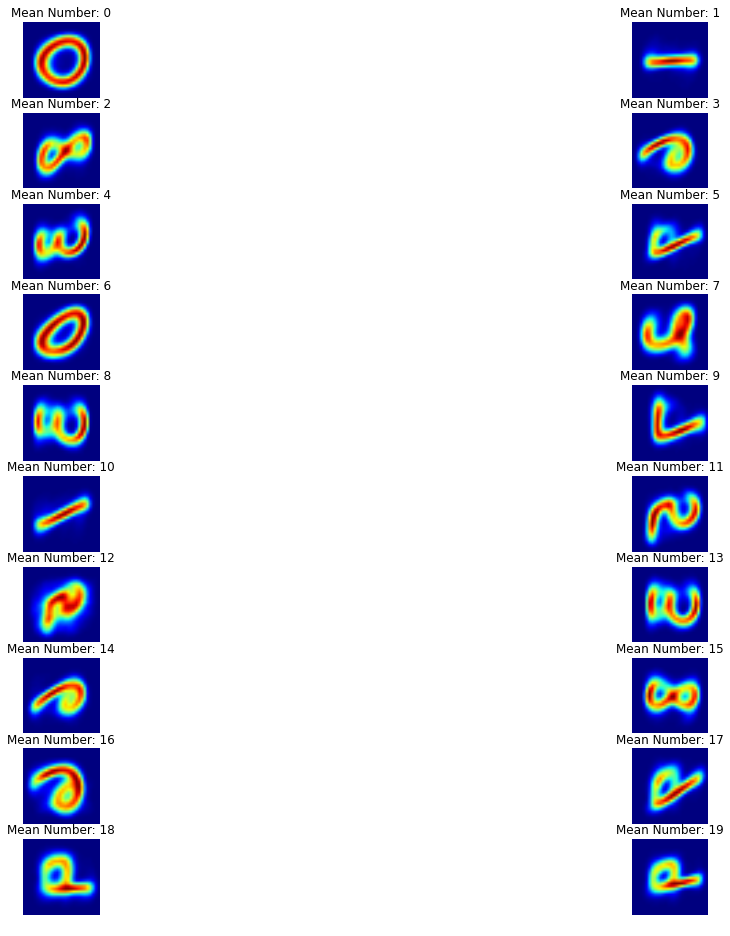

In [127]:
%autoreload
s = np.random.randint(0, 1000)
print(s)
k = 20
km = KMeans(k, it, s).fit(images).plot_means((20,16))

# Problem 2

In [128]:
train = scipy.io.loadmat("joke_data/joke_train.mat")['train']
validation = pd.read_csv("joke_data/validation.txt", header=None)
validation.columns = ['User_Index','Joke_Index', 'Truth']
query = pd.read_csv("joke_data/query.txt", header=None)
query.columns = ['KaggleId', 'User_Index', 'Joke_Index']

## 2.2

In [131]:
recs = pd.DataFrame(train).mean(axis=0).values
avg_preds = validation.Joke_Index.map(lambda x: 1 if recs[x - 1] > 0 else 0)
print("Accuracy via Averages:", sum(validation.Truth == avg_preds) / len(validation))

Accuracy via Averages: 0.620325203252


*knn version*

In [132]:
class KNN:
    def __init__(self, k):
        self.k = k
        self.X = None
        
    def fit(self, X):
        self.X = X
        return self
    
    def inner_predict(self, X):
        for chunk in np.vsplit(X, 43):
            preds = cdist(self.X, chunk, 'euclidean')
            for x_neighbors in preds.T.argsort(axis=1)[:,:self.k]:
                yield self.X[x_neighbors].mean(axis=0)

    def predict(self, X):
        temp = pd.DataFrame(self.inner_predict(X_train), columns=np.arange(1,101)) \
            .applymap(lambda x: 1 if x > 0 else 0)
        temp.index = temp.index + 1
        return temp

In [133]:
X_train = pd.DataFrame(train).fillna(0).values
k = 10
knn = KNN(k)
preds = knn.fit(X_train).predict(X_train)
scores = []
for ((user, joke), rating) in validation.groupby(['User_Index', 'Joke_Index']):
    truth = rating['Truth'].values[0]
    guess = preds.ix[user, joke]
    scores.append(truth == guess)
print("k=%i Accuracy: %.3f" % (k, sum(scores)/len(scores)))

k=10 Accuracy: 0.642


In [134]:
X_train = pd.DataFrame(train).fillna(0).values
k = 100
knn = KNN(k)
preds = knn.fit(X_train).predict(X_train)
scores = []
for ((user, joke), rating) in validation.groupby(['User_Index', 'Joke_Index']):
    truth = rating['Truth'].values[0]
    guess = preds.ix[user, joke]
    scores.append(truth == guess)
print("k=%i Accuracy: %.3f" % (k, sum(scores)/len(scores)))

k=100 Accuracy: 0.689


In [135]:
X_train = pd.DataFrame(train).fillna(0).values
k = 1000
knn = KNN(k)
preds = knn.fit(X_train).predict(X_train)
scores = []
for ((user, joke), rating) in validation.groupby(['User_Index', 'Joke_Index']):
    truth = rating['Truth'].values[0]
    guess = preds.ix[user, joke]
    scores.append(truth == guess)
print("k=%i Accuracy: %.3f" % (k, sum(scores)/len(scores)))

k=1000 Accuracy: 0.694


## 2.3

### 2.3.1 & 2.3.2

In [136]:
import scipy as sp
import scipy.sparse.linalg
mse = lambda y, y_hat: (y_hat - y) ** 2

In [137]:
X_train = pd.DataFrame(train).fillna(0).values

In [170]:
class LFM:
    def __init__(self, k):
        self.u = None
        self.s = None
        self.v = None
        self.k = k
    def fit(self, X):
        u, s, v = sp.sparse.linalg.svds(X, k=self.k)
        self.u = u
        self.s = s
        self.v = v
        temp = pd.DataFrame((self.u * self.s).dot(self.v), columns=np.arange(1,101)) \
                    .applymap(lambda x: 1 if x > 0 else 0)
        temp.index = temp.index + 1
        self.rebuilt = temp
        return self
    def evaluate(self, validation):
        y = []
        y_hat = []
        for ((user, joke), rating) in validation.groupby(['User_Index', 'Joke_Index']):
            truth = rating['Truth'].values[0]
            guess = self.rebuilt.ix[user, joke]
            y.append(truth)
            y_hat.append(guess)
            
        y = pd.Series(y)
        y_hat = pd.Series(y_hat)
        
        error = mse(y, y_hat).sum()
        scores = y == y_hat
        print("k=%i Accuracy: %.3f" % (self.k, sum(scores)/len(scores)))
        return(self.k, sum(scores)/len(scores), error)
    def predict(self, query):
        y_hat = []
        for ((user, joke), identifier) in query.groupby(['User_Index', 'Joke_Index']):
            guess = self.rebuilt.ix[user, joke]
            kId = identifier['KaggleId'].values[0]
            y_hat.append((kId, guess))
            
        y_hat = pd.DataFrame(y_hat)
        y_hat.columns = ["Id", "Category"]
        return y_hat

In [171]:
all_k = []

In [172]:
k=2
lfm = LFM(k=k)
all_k.append(lfm.fit(X_train).evaluate(validation))

k=2 Accuracy: 0.705


In [173]:
k=5
lfm = LFM(k=k)
all_k.append(lfm.fit(X_train).evaluate(validation))

k=5 Accuracy: 0.715


In [174]:
k=10
lfm = LFM(k=k)
all_k.append(lfm.fit(X_train).evaluate(validation))

k=10 Accuracy: 0.717


In [175]:
k=20
lfm = LFM(k=k)
all_k.append(lfm.fit(X_train).evaluate(validation))

k=20 Accuracy: 0.686


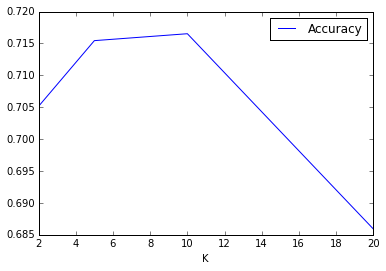

In [176]:
pd.DataFrame(all_k, columns=['K', 'Accuracy', 'MSE']).plot(x='K', y='Accuracy')

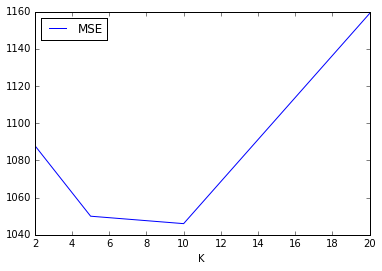

In [177]:
pd.DataFrame(all_k, columns=['K', 'Accuracy', 'MSE']).plot(x='K', y='MSE')

### 2.3.3

In [178]:
regualarized_mse = lambda U, V, truth, weights: np.sum((weights * (truth - U.dot(V))**2))

In [179]:
X_train.shape

(24983, 100)

In [180]:
class RegularizedLFM:
    def __init__(self, k, lamb, n_iters):
        self.U = None
        self.V = None
        self.k = k
        self.n_iters = n_iters
        self.lamb = lamb
        self.errors = []
        
    def fit(self, X_):
        W = pd.DataFrame(X_).notnull().astype(np.float64).values
        X_ = pd.DataFrame(X_).fillna(0).values
        
        U = np.random.normal(size=(len(X_), self.k))
        V = np.random.normal(size=(self.k, len(X_[0])))
        
        for _ in range(self.n_iters):
            U = np.linalg.solve(V.dot(V.T) + self.lamb * np.eye(self.k), V.dot(X_.T)).T
            V = np.linalg.solve(U.T.dot(U) + self.lamb * np.eye(self.k), U.T.dot(X_))
            self.errors.append((_, regualarized_mse(U, V, X_, W)))
            
        self.U = U
        self.V = V
        self.rebuilt = pd.DataFrame(U.dot(V), columns=np.arange(1,101)) \
                            .applymap(lambda x: 1 if x > 0 else 0)
        self.rebuilt.index = self.rebuilt.index + 1
        assert self.rebuilt.shape == X_.shape
        return self
        
    def evaluate(self, validation):
        y = []
        y_hat = []
        for ((user, joke), rating) in validation.groupby(['User_Index', 'Joke_Index']):
            truth = rating['Truth'].values[0]
            guess = self.rebuilt.ix[user, joke]
            y.append(truth)
            y_hat.append(guess)
            
        y = pd.Series(y)
        y_hat = pd.Series(y_hat)
        
        error = mse(y, y_hat).sum()
        scores = y == y_hat
        print("k=%i Accuracy: %.3f" % (self.k, sum(scores)/len(scores)))
        return(self.k, sum(scores)/len(scores), error)
    def predict(self, query):
        y_hat = []
        for ((user, joke), identifier) in query.groupby(['User_Index', 'Joke_Index']):
            guess = self.rebuilt.ix[user, joke]
            kId = identifier['KaggleId'].values[0]
            y_hat.append((kId, guess))
            
        y_hat = pd.DataFrame(y_hat)
        y_hat.columns = ["Id", "Category"]
        return y_hat

In [181]:
all_k = []

In [182]:
k=2
rlfm = RegularizedLFM(k, 1e-6, 15)
all_k.append(rlfm.fit(X_train).evaluate(validation))

k=2 Accuracy: 0.705


In [183]:
k=5
rlfm = RegularizedLFM(k, 1e-6, 15)
all_k.append(rlfm.fit(X_train).evaluate(validation))

k=5 Accuracy: 0.714


In [184]:
k=10
rlfm = RegularizedLFM(k, 1e-6, 15)
all_k.append(rlfm.fit(X_train).evaluate(validation))

k=10 Accuracy: 0.712


In [185]:
k=20
rlfm = RegularizedLFM(k, 1e-6, 15)
all_k.append(rlfm.fit(X_train).evaluate(validation))

k=20 Accuracy: 0.696


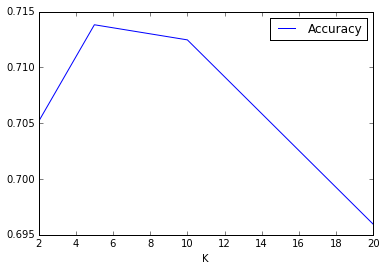

In [186]:
pd.DataFrame(all_k, columns=['K', 'Accuracy', 'MSE']).plot(x='K', y='Accuracy')

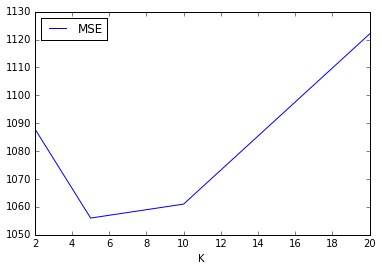

In [187]:
pd.DataFrame(all_k, columns=['K', 'Accuracy', 'MSE']).plot(x='K', y='MSE')

### 2.2.4


In [156]:
k=10
rlfm = RegularizedLFM(k, 1e-6, 15)
all_k.append(rlfm.fit(X_train).evaluate(validation))

k=10 Accuracy: 0.714


In [188]:
preds = rlfm.predict(query)
preds.to_csv("predictions.csv", index=False)

Kaggle Score: 0.6864